In [341]:
%pip install matplotlib
%pip install pandas
%pip install seaborn
%pip install tensorflow
%pip install regressionmetrics

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from datetime import datetime

mpl.rcParams['figure.figsize'] = (12, 10)
mpl.rcParams['axes.grid'] = False

In [ ]:
labels = 'Memory'


In [ ]:
datasetName = 'sharcnet'
dataset = pd.read_csv(f"./datasets/final/final-formed-{datasetName}.csv", delimiter=',', date_format='%Y-%m-%d %H:%M:%S', parse_dates=['Timestamp'])

date_time = pd.to_datetime(dataset['Timestamp'], format='%Y-%m-%d %H:%M:%S')

dataset.drop('Timestamp', axis=1, inplace=True)

if datasetName in ['auvergrid', 'sharcnet']:
    dataset.drop(['cosMonth', 'sinMonth'], axis=1, inplace=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9384 entries, 0 to 9383
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CPUTime        9384 non-null   float64
 1   Memory         9384 non-null   int64  
 2   NJobs          9384 non-null   int64  
 3   NProcs         9384 non-null   int64  
 4   ArrivedJobs    9384 non-null   int64  
 5   CompletedJobs  9384 non-null   int64  
 6   cosHour        9384 non-null   float64
 7   sinHour        9384 non-null   float64
 8   cosDay         9384 non-null   float64
 9   sinDay         9384 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 733.3 KB


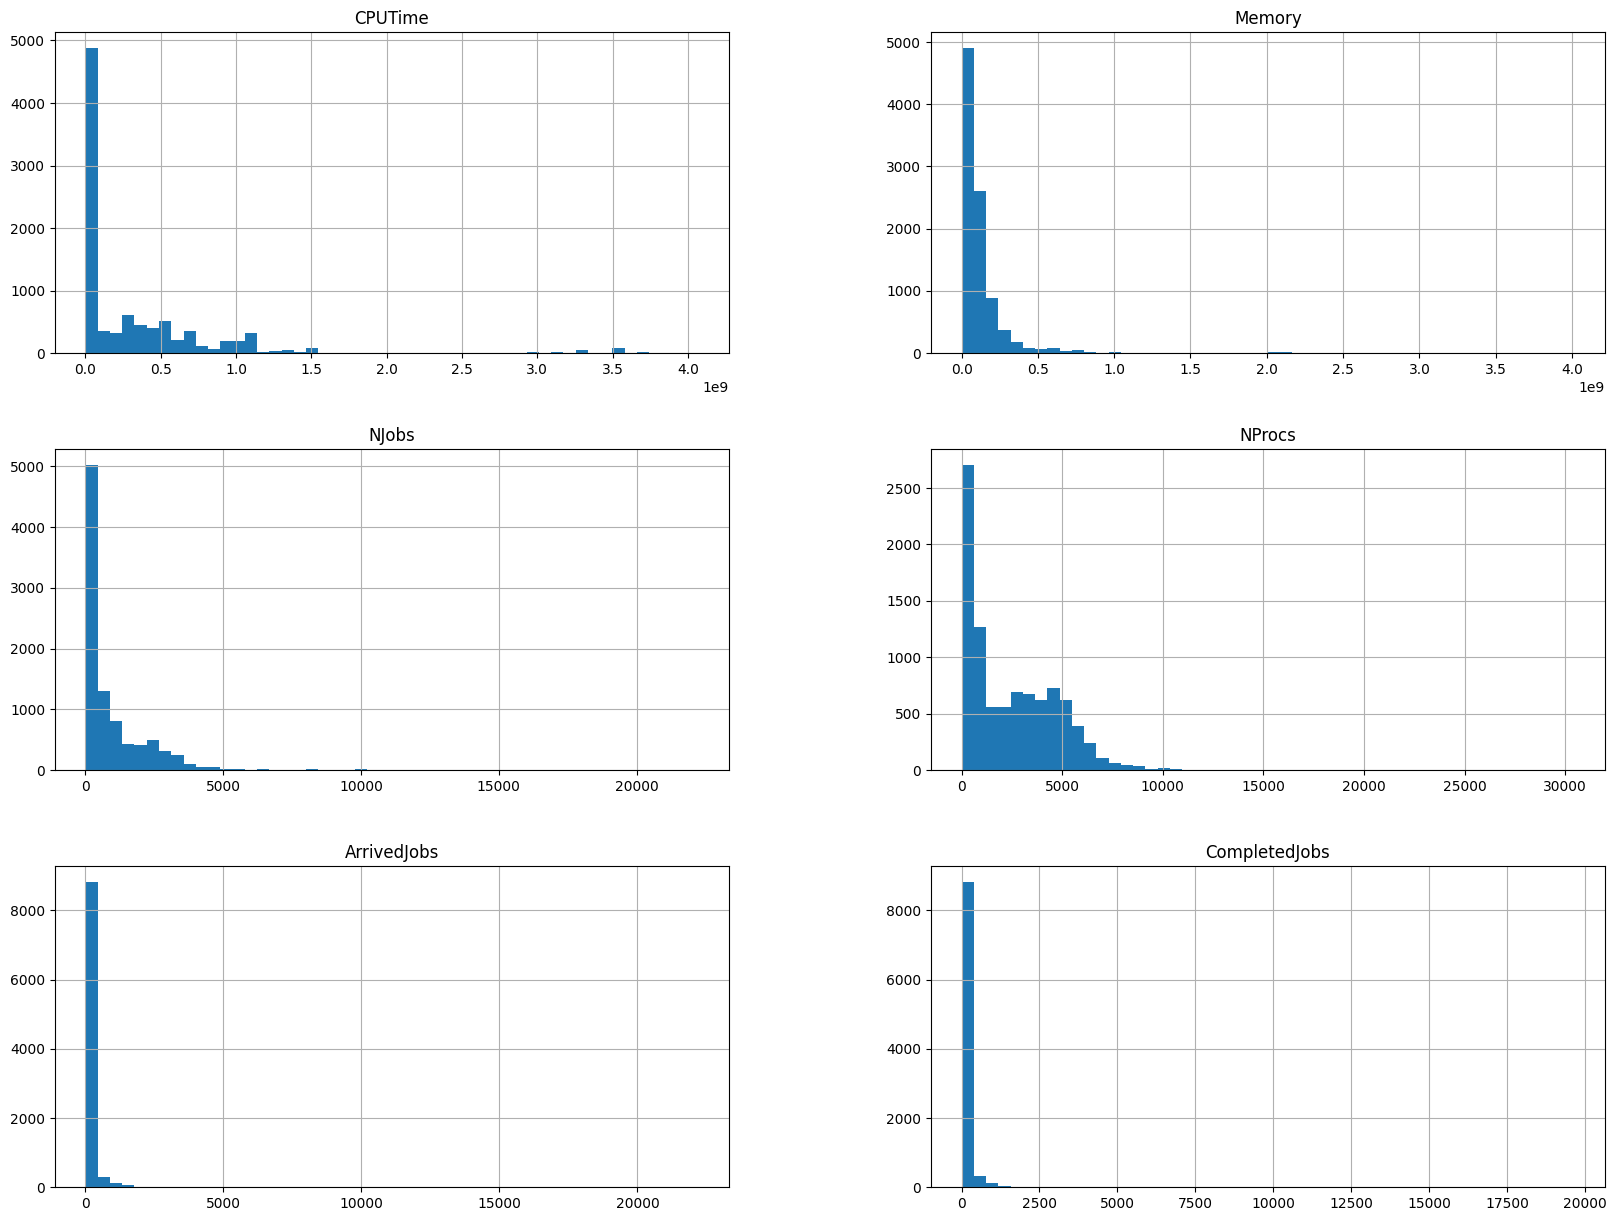

In [ ]:
# Distributions of the data
dataset.iloc[:,:6].hist(bins=50, figsize=(20,15))
plt.show()

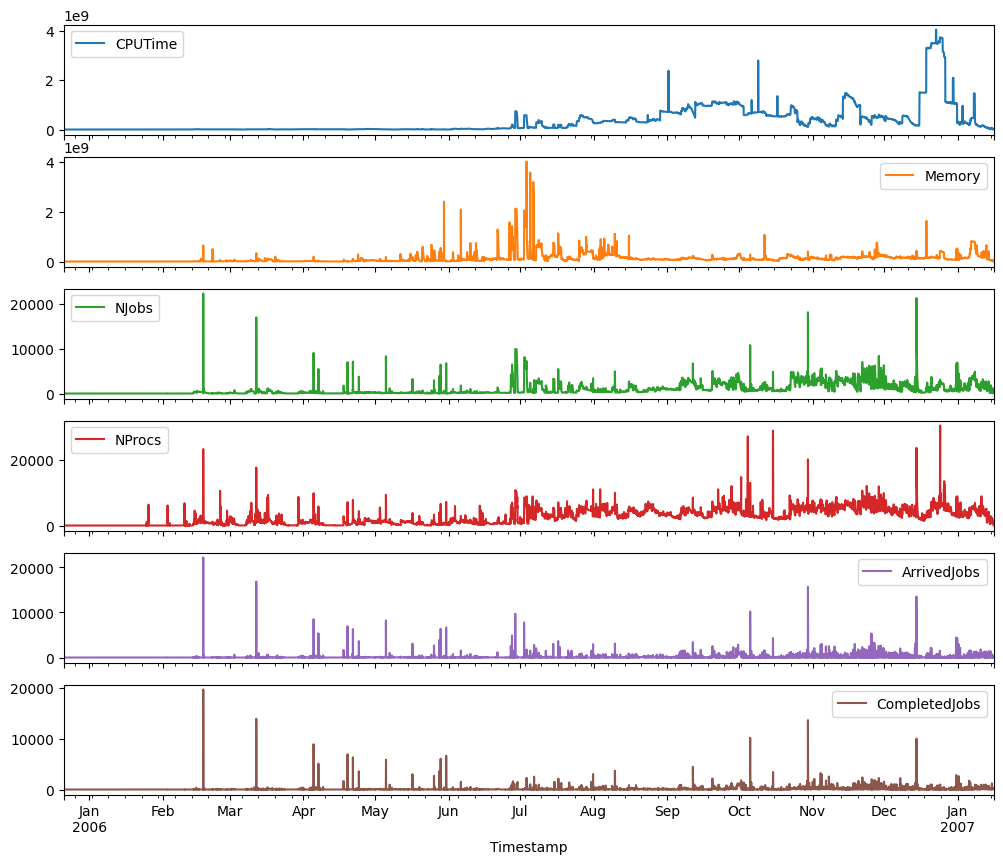

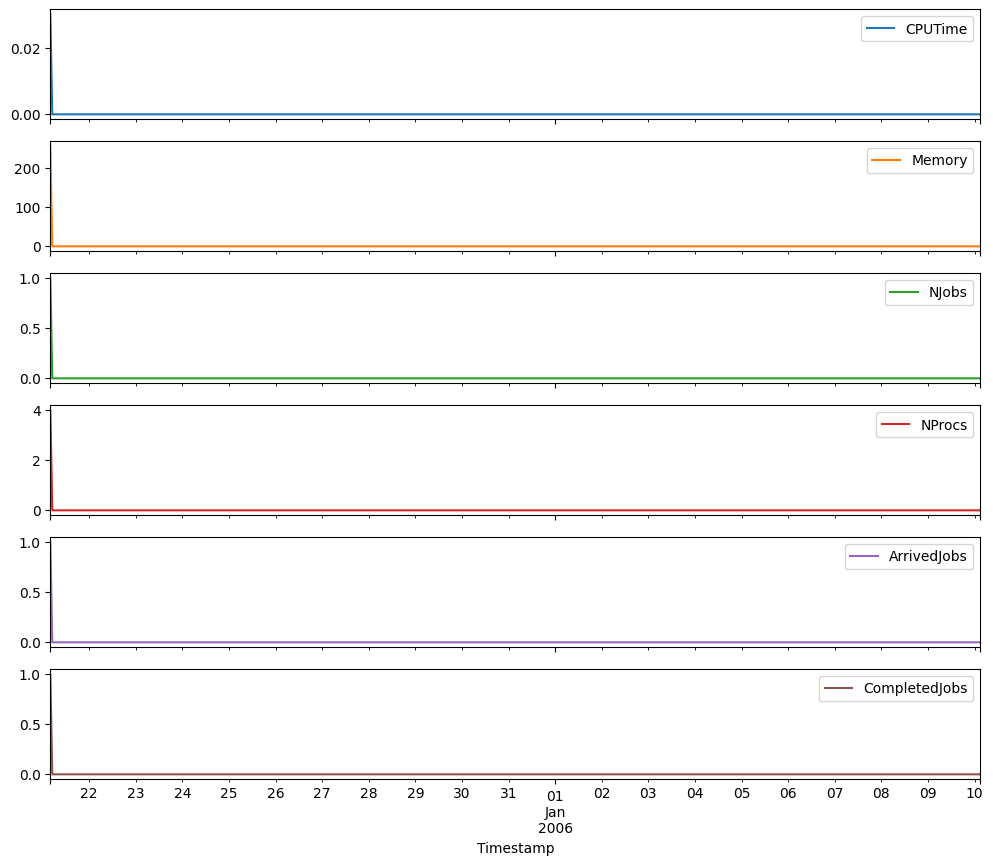

In [ ]:
plot_cols = ['CPUTime', 'Memory', 'NJobs', 'NProcs', 'ArrivedJobs', 'CompletedJobs']
plot_features = dataset[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = dataset[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [ ]:
column_indices = {name: i for i, name in enumerate(dataset.columns)}

n = len(dataset)
train_df = dataset[int(n*0):int(n*0.8)]
test_df = dataset[int(n*0.8):int(n*1.0)]

num_features = dataset.shape[1]

In [ ]:
train_df.head()

,CPUTime,Memory,NJobs,NProcs,ArrivedJobs,CompletedJobs,cosHour,sinHour,cosDay,sinDay
0,0.03,256,1,4,1,1,5.000000e-01,0.866025,0.98522,-0.171293
1,0.00,0,0,0,0,0,2.588190e-01,0.965926,0.98522,-0.171293
2,0.00,0,0,0,0,0,6.123234e-17,1.000000,0.98522,-0.171293
3,0.00,0,0,0,0,0,-2.588190e-01,0.965926,0.98522,-0.171293
4,0.00,0,0,0,0,0,-5.000000e-01,0.866025,0.98522,-0.171293


In [ ]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CPUTime,7507.0,2.137409e+08,3.253036e+08,0.000000,3.680571e+06,1.405139e+07,3.458960e+08,2.806580e+09
Memory,7507.0,1.028800e+08,2.260720e+08,0.000000,6.234914e+06,4.906184e+07,1.063219e+08,4.014616e+09
NJobs,7507.0,6.439867e+02,1.127596e+03,0.000000,2.800000e+01,2.140000e+02,7.455000e+02,2.223500e+04
NProcs,7507.0,1.892868e+03,2.058174e+03,0.000000,2.020000e+02,1.073000e+03,3.214500e+03,2.886800e+04
ArrivedJobs,7507.0,7.924590e+01,4.906709e+02,0.000000,0.000000e+00,8.000000e+00,3.200000e+01,2.219700e+04
CompletedJobs,7507.0,7.886319e+01,4.235852e+02,0.000000,1.000000e+00,1.500000e+01,4.500000e+01,1.965500e+04
cosHour,7507.0,-6.001044e-04,7.070014e-01,-1.000000,-7.071068e-01,-1.836970e-16,7.071068e-01,1.000000e+00
sinHour,7507.0,-1.607975e-04,7.073061e-01,-1.000000,-7.071068e-01,0.000000e+00,7.071068e-01,1.000000e+00
cosDay,7507.0,-1.306382e-01,6.785203e-01,-0.999963,-7.775971e-01,-2.177232e-01,4.366512e-01,1.000000e+00
sinDay,7507.0,9.469659e-02,7.167330e-01,-0.999991,-6.551564e-01,2.219215e-01,7.802959e-01,9.999907e-01


In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

def scale(data, column):
    return (data - train_mean[column]) / train_std[column]

def descale(data, column):
    return (data * train_std[column]) + train_mean[column]

# train_df = scale(train_df, train_df.columns)

In [ ]:
train_df.head()

,CPUTime,Memory,NJobs,NProcs,ArrivedJobs,CompletedJobs,cosHour,sinHour,cosDay,sinDay
0,0.03,256,1,4,1,1,5.000000e-01,0.866025,0.98522,-0.171293
1,0.00,0,0,0,0,0,2.588190e-01,0.965926,0.98522,-0.171293
2,0.00,0,0,0,0,0,6.123234e-17,1.000000,0.98522,-0.171293
3,0.00,0,0,0,0,0,-2.588190e-01,0.965926,0.98522,-0.171293
4,0.00,0,0,0,0,0,-5.000000e-01,0.866025,0.98522,-0.171293


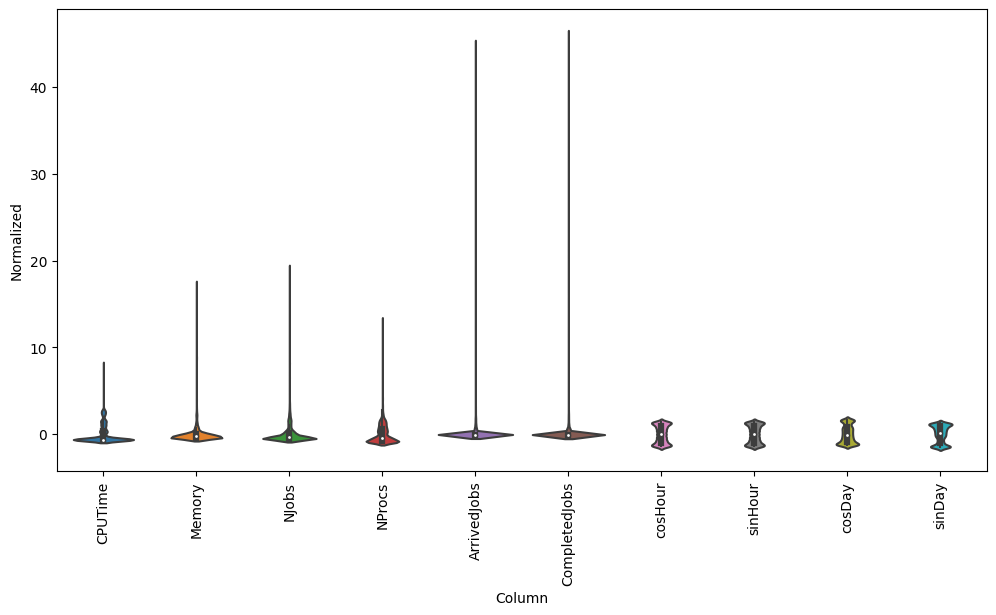

In [ ]:
train_df = scale(train_df, train_df.columns)
df_std = train_df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(dataset.keys(), rotation=90)
train_df = descale(train_df, train_df.columns)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 


### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [ ]:
import numpy as np

class WindowGenerator():
    def __init__(self, input_width, label_width, shift, label_columns, train_df = train_df, test_df = test_df):
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.label_columns = label_columns

        self.train_df = train_df
        self.test_df = test_df

        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}


In [ ]:
def split_window(self, features):
    inputs = features[:, :self.input_width]
    labels = features[:, self.input_width:]
    if self.label_columns is not None:
        labels = labels[:, [self.label_columns_indices[label] for label in self.label_columns]]
    return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def make_dataset(self, data):
    features = np.array(data, dtype=np.float32)
    labels = np.array(data.iloc[:, [self.column_indices[column] for column in self.label_columns]], dtype=np.float32)
    ds_features = []
    ds_labels = []
    for i in range(len(data) - self.total_window_size + 1):
        ds_features.append(features[i:i+self.input_width][0])
        ds_labels.append(labels[i+self.input_width:i+self.total_window_size][0])
    ds_features = np.array(ds_features)
    ds_labels = np.array(ds_labels)

    return ds_features, ds_labels

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
    inputs, labels = self.make_dataset(self.train_df)
    return inputs, labels

@property
def test(self):
    inputs, labels = self.make_dataset(self.test_df)
    return inputs, labels

@property
def example(self):
    return self.train  # Return the training dataset for plotting

WindowGenerator.train = train
WindowGenerator.test = test
WindowGenerator.example = example


In [ ]:
me_performance = {}
mae_performance = {}
r2_performance = {}
prmse_performance = {}
fitTimes = {}

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=[labels])


x_train, y_train = window.train
x_test, y_test = window.test

# Create and fit the regression model
regression_model = LinearRegression()
start = datetime.now()
regression_model.fit(x_train, y_train)
end = datetime.now()
fitTimes["Linear Regression"] = (end - start).total_seconds()

# Make predictions using the regression model
y_pred = regression_model.predict(x_test)

# y_pred = descale(y_pred, labels)
# y_test = descale(y_test, labels)

me = np.sum(y_test - y_pred) / (len(y_test)*np.mean(y_test))
normalised_me = me / np.mean(y_test)

mae = mean_absolute_error(y_test, y_pred)
normalised_MAE = mae / np.mean(y_test)

r2 = r2_score(y_test, y_pred)
prmse = np.sqrt(np.mean((y_test - y_pred)**2)) / (np.max(y_test) - np.min(y_test)) * 100

me_performance["Linear Regression"] = normalised_me*100
mae_performance["Linear Regression"] = normalised_MAE*100
r2_performance["Linear Regression"] = r2
prmse_performance["Linear Regression"] = prmse


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error
import joblib

window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=[labels])

x_train, y_train = window.train
x_test, y_test = window.test

try:
    print("Loading Lasso Grid...")
    lasso_grid = joblib.load( f'pkl/lasso_grid_{datasetName}-{labels}.pkl')
except:
    print("Lasso Grid not found. Creating...")
    lasso = Lasso()
    lasso_params = {'alpha': [1, 100, 1e4, 1e6], 'max_iter': [10000000]} 
    lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    start = datetime.now()
    lasso_grid.fit(x_train, y_train)
    end = datetime.now()
    fitTimes["Lasso"] = (end - start).total_seconds()

try:
    print("Loading Ridge Grid...")
    ridge_grid = joblib.load( f'pkl/ridge_grid_{datasetName}-{labels}.pkl')
except:
    print("Ridge Grid not found. Creating...")
    ridge = Ridge()
    ridge_params = {'alpha': [1e-10, 1e-5, 1e-4, 1e-2, 1e-1, 1], 'max_iter': [10000000]}
    ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    start = datetime.now()
    ridge_grid.fit(x_train, y_train)
    end = datetime.now()
    fitTimes["Ridge"] = (end - start).total_seconds()

try:
    print("Loading Elastic Grid...")
    elastic_grid = joblib.load(f'pkl/elastic_grid_{datasetName}-{labels}.pkl')
except:
    print("Elastic Grid not found. Creating...")
    elastic = ElasticNet()
    elastic_params = {'alpha': [1, 10, 20, 40, 80, 160, 240], 'max_iter': [10000000]}
    elastic_grid = GridSearchCV(elastic, elastic_params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    start = datetime.now()
    elastic_grid.fit(x_train, y_train)
    end = datetime.now()
    fitTimes["Elastic Net"] = (end - start).total_seconds()

joblib.dump(lasso_grid, f'pkl/lasso_grid_{datasetName}-{labels}.pkl')
joblib.dump(ridge_grid, f'pkl/ridge_grid_{datasetName}-{labels}.pkl')
joblib.dump(elastic_grid, f'pkl/elastic_grid_{datasetName}-{labels}.pkl')

# Make predictions using the tuned models
y_pred_lasso = lasso_grid.predict(x_test)
y_pred_ridge = ridge_grid.predict(x_test)
y_pred_elastic = elastic_grid.predict(x_test)

me_lasso = np.sum(y_test - y_pred_lasso) / (len(y_test)*np.mean(y_test))
me_ridge = np.sum(y_test - y_pred_ridge) / (len(y_test)*np.mean(y_test))
me_elastic = np.sum(y_test - y_pred_elastic) / (len(y_test)*np.mean(y_test))

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mae_elastic = mean_absolute_error(y_test, y_pred_elastic)

normalised_ME_lasso = me_lasso / np.mean(y_test)
normalised_ME_ridge = me_ridge / np.mean(y_test)
normalised_ME_elastic = me_elastic / np.mean(y_test)

normalised_MAE_lasso = mae_lasso / np.mean(y_test)
normalised_MAE_ridge = mae_ridge / np.mean(y_test)
normalised_MAE_elastic = mae_elastic / np.mean(y_test)

r2_lasso = r2_score(y_test, y_pred_lasso)
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_elastic = r2_score(y_test, y_pred_elastic)

prmse_lasso = np.sqrt(np.mean((y_test - y_pred_lasso)**2)) / (np.max(y_test) - np.min(y_test)) * 100
prmse_ridge = np.sqrt(np.mean((y_test - y_pred_ridge)**2)) / (np.max(y_test) - np.min(y_test)) * 100
prmse_elastic = np.sqrt(np.mean((y_test - y_pred_elastic)**2)) / (np.max(y_test) - np.min(y_test)) * 100

me_performance["Lasso"] = normalised_ME_lasso*100
me_performance["Ridge"] = normalised_ME_ridge*100
me_performance["Elastic Net"] = normalised_ME_elastic*100

mae_performance["Lasso"] = normalised_MAE_lasso*100
mae_performance["Ridge"] = normalised_MAE_ridge*100
mae_performance["Elastic Net"] = normalised_MAE_elastic*100

r2_performance["Lasso"] = r2_lasso
r2_performance["Ridge"] = r2_ridge
r2_performance["Elastic Net"] = r2_elastic

prmse_performance["Lasso"] = prmse_lasso
prmse_performance["Ridge"] = prmse_ridge
prmse_performance["Elastic Net"] = prmse_elastic


mae_performance


Loading Lasso Grid...
Loading Ridge Grid...
Loading Elastic Grid...


{'Linear Regression': 25.592970848083496,
 'Lasso': 368.638014793396,
 'Ridge': 365.60120582580566,
 'Elastic Net': 370.84107398986816}

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=[labels])

x_train, y_train = window.train
x_test, y_test = window.test

try:
    print("Loading Polynomial Grid...")
    poly_grid = joblib.load(f'pkl/poly_grid_{datasetName}-{labels}.pkl')
except:
    poly = PolynomialFeatures()
    linear = LinearRegression()
    pipe = Pipeline([('poly', poly), ('linear', linear)])
    params = {'poly__degree': [1, 2, 3]}
    poly_grid = GridSearchCV(pipe, params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    start = datetime.now()
    poly_grid.fit(x_train, y_train)
    end = datetime.now()
    fitTimes["Polynomial Regression"] = (end - start).total_seconds()

joblib.dump(poly_grid, f'pkl/poly_grid_{datasetName}-{labels}.pkl')

y_pred_poly = poly_grid.predict(x_test)

me_poly = np.sum(y_test - y_pred_poly) / (len(y_test)*np.mean(y_test))
mae_poly = mean_absolute_error(y_test, y_pred_poly)

normalised_ME_poly = me_poly / np.mean(y_test)
normalised_MAE_poly = mae_poly / np.mean(y_test)

r2_poly = r2_score(y_test, y_pred_poly)
prmse_poly = np.sqrt(np.mean((y_test - y_pred_poly)**2)) / (np.max(y_test) - np.min(y_test)) * 100

me_performance["Polynomial Regression"] = normalised_ME_poly*100
mae_performance["Polynomial Regression"] = normalised_MAE_poly*100
r2_performance["Polynomial Regression"] = r2_poly
prmse_performance["Polynomial Regression"] = prmse_poly

mae_performance 


Loading Polynomial Grid...


{'Linear Regression': 25.592970848083496,
 'Lasso': 368.638014793396,
 'Ridge': 365.60120582580566,
 'Elastic Net': 370.84107398986816,
 'Polynomial Regression': 370.8503246307373}

In [ ]:
poly_grid.best_params_

{'poly__degree': 1}

In [ ]:
me_performance

{'Linear Regression': -2.821128775861962e-09,
 'Lasso': -0.003571654552381705,
 'Ridge': -1.88630042855799e-06,
 'Elastic Net': -0.0035939866188709852,
 'Polynomial Regression': -1.915824420474213e-06}

In [ ]:
mae_performance

{'Linear Regression': 25.592970848083496,
 'Lasso': 368.638014793396,
 'Ridge': 365.60120582580566,
 'Elastic Net': 370.84107398986816,
 'Polynomial Regression': 370.8503246307373}

In [ ]:
fitTimes

{'Linear Regression': 0.009789}

In [ ]:
r2_performance

{'Linear Regression': 0.6663185467402912,
 'Lasso': -70.90530462447077,
 'Ridge': -69.30967796858604,
 'Elastic Net': -72.19816746967778,
 'Polynomial Regression': -72.2030717013897}

In [ ]:
prmse_performance

{'Linear Regression': 4.742813482880592,
 'Lasso': 70.14225721359253,
 'Ridge': 68.84582042694092,
 'Elastic Net': 70.76925039291382,
 'Polynomial Regression': 70.24810910224915}

In [ ]:
fitTimes["Lasso"] = 7394.46
fitTimes["Ridge"] = 1.324
fitTimes["Elastic Net"] = 11461.59
fitTimes["Polynomial Regression"] = 2.46

In [ ]:
for key in mae_performance:
    print(f"fitTimes['{key}'] = {fitTimes[key]}")
    print(f"performance['{key}'] = [{mae_performance[key]/100}, {me_performance[key]/100}, {r2_performance[key]}, {prmse_performance[key]}]")

fitTimes['Linear Regression'] = 0.009789
performance['Linear Regression'] = [0.25592970848083496, -2.821128775861962e-11, 0.6663185467402912, 4.742813482880592]
fitTimes['Lasso'] = 7394.46
performance['Lasso'] = [3.68638014793396, -3.571654552381705e-05, -70.90530462447077, 70.14225721359253]
fitTimes['Ridge'] = 1.324
performance['Ridge'] = [3.6560120582580566, -1.88630042855799e-08, -69.30967796858604, 68.84582042694092]
fitTimes['Elastic Net'] = 11461.59
performance['Elastic Net'] = [3.7084107398986816, -3.593986618870985e-05, -72.19816746967778, 70.76925039291382]
fitTimes['Polynomial Regression'] = 2.46
performance['Polynomial Regression'] = [3.708503246307373, -1.915824420474213e-08, -72.2030717013897, 70.24810910224915]


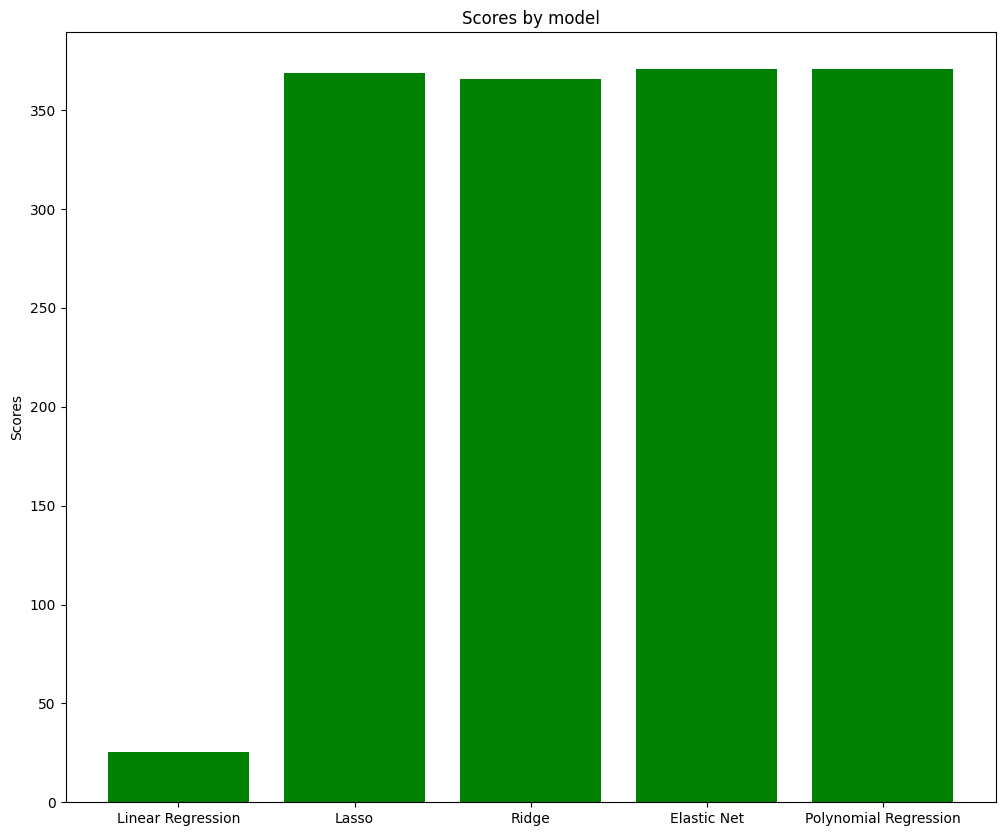

In [ ]:
x = np.arange(len(me_performance))
fig, ax = plt.subplots()
rects1 = ax.bar(x, mae_performance.values(), label='MAE', color='g')
ax.set_ylabel('Scores')
ax.set_title('Scores by model')
ax.set_xticks(x, list(me_performance.keys()))
plt.show()

<BarContainer object of 10 artists>

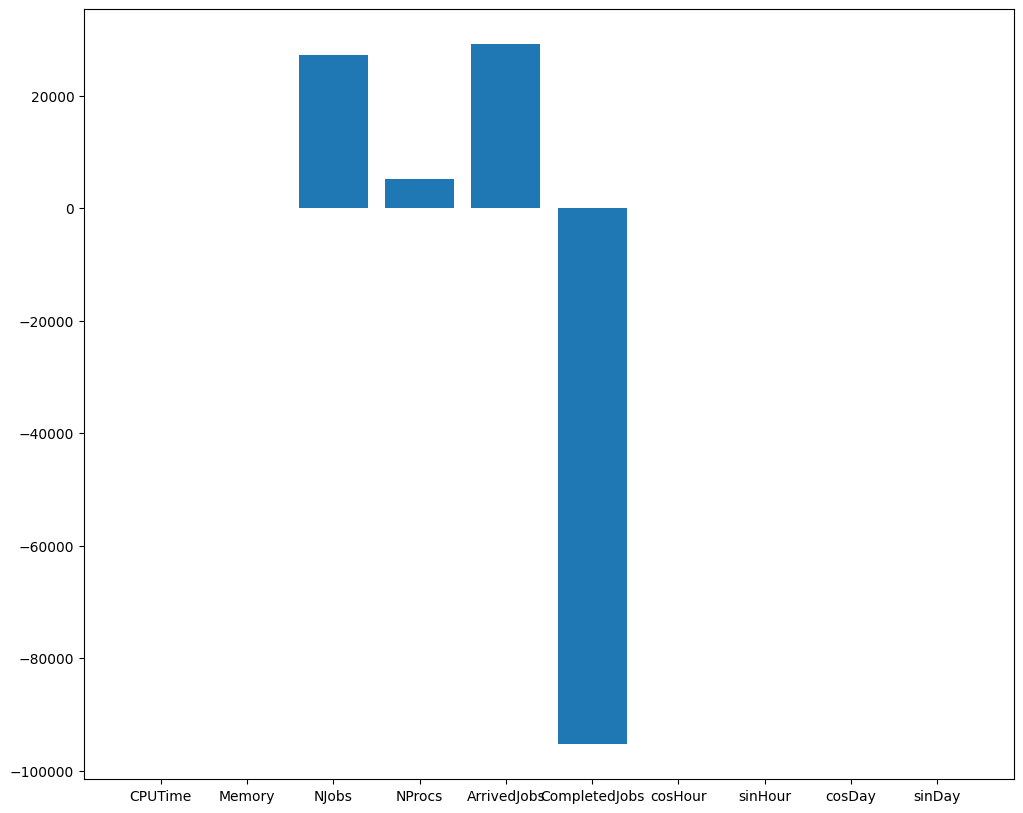

In [ ]:
plt.bar(train_df.columns, regression_model.coef_[0])